# Recovering job from ID

This document shows you how to recover job from its ID.

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Transpiled Quantum Circuit

Example of a quantum circuit without ancilla qubits before transpilation.

### Define quantum circuit

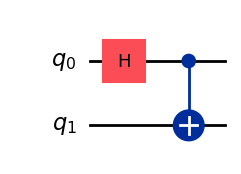

In [16]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl", style="iqp")

### Transpile circuit

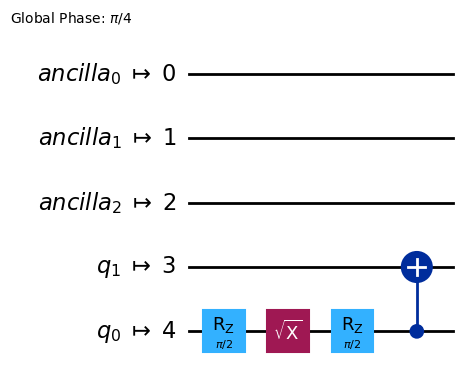

In [17]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()
backend.set_options(seed_simulator=25)
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

# Transpile the circuit to an "Instruction Set Architecture" (ISA) circuit.
# Note: the transpiler automatically adds "ancilla" qubits to make the transpiled
# circuit match the size of the FakeManilaV2 backend.
qc_isa = pm.run(qc)
qc_isa.draw("mpl", style="iqp")

### Define measurement procedure

No need to set a particular `measurement_layout`, because the `POVMSampler` will analyze the transpiled circuit and apply the `TranspileLayout` to the measurement circuit.

In [18]:
from povm_toolbox.library import ClassicalShadows

measurement = ClassicalShadows(2, measurement_layout=None, seed_rng=13)

More precisely, the measurement layout that will be automatically applied by the `POVMSampler` is extracted as :
```python
transpile_layout = transpiled_circuit.layout
measurement_layout = transpile_layout.final_index_layout(filter_ancillas=True)
```
For the above circuit, we have:

In [19]:
print(qc_isa.layout.final_index_layout(filter_ancillas=True))

[4, 3]


### Run the job

Initialize `Sampler` and `POVMSampler`. Then run the job.

In [20]:
from povm_toolbox.sampler import POVMSampler
from qiskit_ibm_runtime import SamplerV2 as RuntimeSampler

# First define a standard sampler (that will be used under the hood).
runtime_sampler = RuntimeSampler(backend=backend)
# Then define the POVM sampler, which takes BaseSampler as an argument.
povm_sampler = POVMSampler(runtime_sampler)
# Submit the job by specifying which POVM to use, which circuit(s) to measure and the shot budget.
job = povm_sampler.run(pubs=[qc_isa], shots=4096, povm=measurement)

Look at the final composed circuit to check that the measurement was performed on the correct qubits.

In [21]:
pubs = job.base_job._args[0]
pub = pubs[0]
pub.circuit

In [22]:
d = job.metadata[0].to_dict()
d

{'metadata_module': 'povm_toolbox.library.metadata.rpm_metadata',
 'metadata_class': 'RPMMetadata',
 'metadata_as_dict': {'povm_module': 'povm_toolbox.library.classical_shadows',
  'povm_class': 'ClassicalShadows',
  'povm_kwargs': {'n_qubit': 2,
   'measurement_twirl': False,
   'measurement_layout': None,
   'shot_batch_size': 1,
   'seed_rng': {'bit_generator': 'PCG64',
    'state': {'state': 22979575097456486551925911748066631365,
     'inc': 317612346296202158696945144441957901887},
    'has_uint32': 0,
    'uinteger': 0}},
  'composed_circuit_qasm3': 'OPENQASM 3.0;\ninclude "stdgates.inc";\ninput float[64] _phi_0_;\ninput float[64] _phi_1_;\ninput float[64] _theta_0_;\ninput float[64] _theta_1_;\nbit[2] povm_measurement_creg;\nrz(pi/2) $4;\nsx $4;\nrz(pi/2) $4;\ncx $4, $3;\nrz(-1.0*_phi_0_) $4;\nsx $4;\nrz(pi - _theta_0_) $4;\nsx $4;\nrz(3*pi) $4;\nrz(-1.0*_phi_1_) $3;\nsx $3;\nrz(pi - _theta_1_) $3;\nsx $3;\nrz(3*pi) $3;\npovm_measurement_creg[0] = measure $4;\npovm_measurement_

In [23]:
import json

json_str = json.dumps(d)

In [24]:
json_dict = json.loads(json_str)

In [25]:
from povm_toolbox.library.metadata import POVMMetadata

metadata = POVMMetadata.from_dict(json_dict)
metadata

RPMMetadata(povm_implementation=ClassicalShadows(n_qubits=2), composed_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x323f36b10>, pvm_keys=np.ndarray<4096,2>)

In [26]:
job.save_povm_metadata("saved_metadata")

In [27]:
job_metadata = job.load_povm_metadata("saved_metadata")
print(job_metadata)

[RPMMetadata(povm_implementation=ClassicalShadows(n_qubits=2), composed_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3240c7260>, pvm_keys=np.ndarray<4096,2>)]
